
# Hypothesis: We can accurately approximate a solution to the Shallow Water Equations on the sphere using a spectral method to compute the derivatives.



The Shallow Water Equations on the sphere consist of momentum equations for $u$ and $v$ and a mass continuity equation, as follows:


$$\frac{\partial u}{\partial t} + \mathbf{v} \cdot \nabla u - \left( f + \frac{u}{a} \tan{\theta} \right) v + \frac{g}{a \cos{\theta}} \frac{\partial h}{\partial \lambda} = 0,$$


$$\frac{\partial v}{\partial t} + \mathbf{v} \cdot \nabla v - \left( f + \frac{u}{a} \tan{\theta} \right) u + \frac{g}{a} \frac{\partial h}{\partial \theta} = 0,$$


$$\frac{\partial h^*}{\partial t} + \mathbf{v} \cdot \nabla h^* + \frac{h^*}{a \cos{\theta}} \left( \frac{\partial u}{\partial \lambda} + \frac{\partial v \cos{\theta}}{\partial \theta} \right) = 0,$$

where:

$h^*$ is the depth of the fluid,

$h$ is the height of the free surface above sea level, 

$\mathbf{v}$ is the velocity, with components $u$ and $v$ in the longitudinal ($\lambda$) and latitudinal ($\theta$) directions, respectively,

$f$ is the Coriolis parameter ($f=2 \Omega \sin{\theta}$, where $\Omega$ is the rotation rate of the earth),

$g$ is the gravitational constant, 

$a$ is the radius of the earth, and

$t$ is time.  

## Process:

(1) Make the domain:  We specify a height field, then create a function which does the following:

    (i) reflects the domain about its North edge,

    (ii) flips this mirrored domain about the vertical axis (the prime meridian),

    (iii) stitch this flipped domain's bottom edge to the top edge of the original domain, creating a periodic space.  

<img src="GridPic.png">

(2) Evaluate the derivatives spectrally (using FFT).

(3) Utilize a polar filter.

(4) Progess through time using a temporal discretization (third order Runge-Kutta), as follows:

Let $\frac{d\phi}{dt} = F(\phi,t)$.

Third order Runge-Kutta (RK3) time integration can be computed as:

$$ \phi^\star = \phi^n + \frac{\Delta t}{3} F(\phi^n) $$

$$ \phi^{\star \star} = \phi^n + \frac{\Delta t}{2} F(\phi^\star) $$

$$ \phi^{n+1} = \phi^n + \Delta t F(\phi^{\star \star}) $$


(5) Run the model.  We test our model using the first test presented in "A Standard Test Set for Numerical Approximations to the Shallow Water Equations in Spherical Geometry" by Williamson et. al.  This test checks the ability of the continuity equation to simulate advection of a cosine bell structure. 

The advecting wind is as follows:

$$ u = u_0 \left( \cos{\theta} \cos{\alpha} + \sin{\theta} \cos{\lambda} \sin{\alpha} \right) $$

$$ v = - u_0 \sin{\lambda} \sin{\alpha}, $$

where $\alpha$ is the angle between the axis of solid body rotation and the polar axis of the spherical coordinate system.

We advect the following cosine bell:

$$  
h(\lambda,\theta) =     \left\{
\begin{array}{ll}
      \left( \frac{h_0}{2} \right) \left( 1 + \cos{\frac{\pi r}{R}} \right) & \text{if} \enspace r < R \\
      0 & \text{if} \enspace r \geq R, \\
\end{array} 
\right.  
$$

where $h_0 = 1000$ m and $r$ is the great circle distance between $(\lambda,\theta)$ and the center, which is initially taken as $(\lambda_c,\theta_c) = (3 \pi/2,0)$:

$$r = a \arccos [\sin{\theta_c} \sin{\theta} + \cos{\theta_c} \cos{\theta} \cos{(\lambda - \lambda_c)}].$$

The radius $R= \frac{a}{3}$ and the initial advecting wind velocity $u_0= \frac{2 \pi a}{12 \thinspace \text{days}} \approx 40 \thinspace \text{m/s}. $

(6) Plot results and analyze error.  


In [3]:
#object oriented approach to shallow water model

#state variables native to class are:
#lat
#lon
#Height
#u  Should update eventually (right now u and v are basically forcing terms for the advection)
#v  Should update eventually

%matplotlib inline

from __future__ import division
#import numpy as np
from numpy import *
import pylab as PP
import math as math

def MirrorAndFlipDomain(lat,lon,H,u,v):
    """
    This function will take in a height field (domain) and mirror it about it's top (north) edge and then flip the
    mirrored about the vertical axis (prime meridion) and stich the 2nd domain's bottom edge to the top edge of the
    input domain
    """
    H2 = flipud(H)
    H2 = fliplr(H2)
    H2 = vstack((H2,H))
    
    u2 = flipud(u)
    u2 = fliplr(u2)
    u2 = vstack((u2,u))
    
    v2 = flipud(v)
    v2 = fliplr(v2)
    v2 = vstack((v2,v))
    
    mirror_lat = hstack(lat,fliplr(lat))
    
    return H2,u2,v2,mirror_lat


def ddx2_filter(lat,lon,H):
    """
    this function is the two dimensional version of ddx, it takes in 
    lat and lon vectors as well as some field H
    """
    i = 1j
    
    hy = fft.rfft(H,axis=0)
    hx = fft.rfft(H,axis=1)
    
    kx = arange(0,len(hx[0,:]))
    #helper variable for the y direction
    ky = arange(0,len(hy[:,0]))
    
    # apply the polar filter for the meridional (y) direction
    y_tilde_deriv = i*multiply(ky[:,newaxis],hy)
    kmax = int(ceil(2*y_tilde_deriv.shape[1]/3.))
    y_tilde_deriv[argmin(abs(lat - pi/3)):,kmax:] = 0.0
    y_tilde_deriv[0:argmin(abs(lat + pi/3)),kmax:] = 0.0
    
    
    dkx = fft.irfft(i*multiply(kx[newaxis,:],hx),axis=1,n=H.shape[1])
    dky = fft.irfft(y_tilde_deriv,axis=0,n=H.shape[0])
    
    return dkx,dky

def ddx2(lat,lon,H):
    """
    this function is the two dimensional version of ddx, it takes in 
    lat and lon vectors as well as some field H
    """
    i = 1j
    
    hy = fft.rfft(H,axis=0)
    hx = fft.rfft(H,axis=1)
    
    kx = arange(0,len(hx[0,:]))
    #helper variable for the y direction
    ky = arange(0,len(hy[:,0]))
    
    dkx = fft.irfft(i*multiply(kx[newaxis,:],hx),axis=1,n=H.shape[1])
    dky = fft.irfft(i*multiply(ky[:,newaxis],hy),axis=0,n=H.shape[0])
    
    return dkx,dky


class JLNmodel:
    
    """
    This is the model
    """
    
    
    def __init__(self,lon,lat,H,u,v):
        
        """
        Initializes the model initial conditions
        """
        self.omega = 7.292*10**-5
        self.lon = lon
        self.lat = lat
        self.height_initial = H
        self.height_current = H
        self.h_star = H
        self.h_starstar = H
        self.u_initial = u
        self.u_current = u
        self.v_initial = v
        self.v_current = v
        self.dkx = empty([len(self.lat),len(self.lon)])
        self.dky = empty([len(self.lat),len(self.lon)])
        self.htend = empty([len(self.lat),len(self.lon)])
        self.utend = empty([len(self.lat),len(self.lon)])
        self.vtend = empty([len(self.lat),len(self.lon)])
        self.f = 2*self.omega*sin(meshgrid(self.lon,self.lat)[1])
        self.istest = False
        self.time_steps = 0
        
    def ddx2_filter(self):
        """
        this function is the two dimensional version of ddx, it takes in 
        lat and lon vectors as well as some field H
        """
        i = 1j
    
        hy = fft.rfft(self.height_current,axis=0)
        hx = fft.rfft(self.height_current,axis=1)
    
        kx = arange(0,len(hx[0,:]))
        #helper variable for the y direction
        ky = arange(0,len(hy[:,0]))
        
        # apply the polar filter for the meridional (y) direction
        y_tilde_deriv = i*multiply(ky[:,newaxis],hy)
        kmax = int(ceil(2*y_tilde_deriv.shape[1]/3.))
        y_tilde_deriv[argmin(abs(lat - pi/3)):,kmax:] = 0.0
        y_tilde_deriv[0:argmin(abs(lat + pi/3)),kmax:] = 0.0
        
        self.dkx = fft.irfft(i*multiply(kx[newaxis,:],hx),axis=1,n=self.height_current.shape[1])
        self.dky = fft.irfft(y_tilde_deriv,axis=0,n=self.height_current.shape[0])
    
        return self
    
    
    def ddx2(self):
        """
        this function is the two dimensional version of ddx, it takes in 
        lat and lon vectors as well as some field H
        """
        i = 1j
    
        hy = fft.rfft(self.height_current,axis=0)
        hx = fft.rfft(self.height_current,axis=1)
    
        kx = arange(0,len(hx[0,:]))
        #helper variable for the y direction
        ky = arange(0,len(hy[:,0]))
        
        self.dkx = fft.irfft(i*multiply(kx[newaxis,:],hx),axis=1,n=self.height_current.shape[1])
        self.dky = fft.irfft(i*multiply(ky[:,newaxis],hy),axis=0,n=self.height_current.shape[0])
    
        return self
    
    def tendency(self):
        """
        calculate equation (13) from williamson paper as the height tendencies
        calculate equation (11) from williamson paper as the u tendencies
        calculate equation (12) from williamson paper as the v tendencies
        """
        #radius of the earth in m
        a = 6.37122 * 10**6
        g = 9.8
        #make a grid like lon and lat
        xx,yy = meshgrid(self.lon,self.lat)
        
        #calculate the derivatives with respect to lon (dkx) and lat (dky) of the curent height field
        dhdx,dhdy = ddx2(self.lat,self.lon,self.height_current)
        
        #calculate the gradient in spherical coordinates as eq (3) in williamson
        #gradH[0] i hat
        #gradH[1] j hat
        gradH = [dhdx*(1/(a*cos(yy))),dhdy/a]
        
        #horizontal wind dotted with gradiant of H
        first_term = self.u_current * gradH[0] +self.v_current*gradH[1]
        
        #derivative of zonal wind in x and y direction
        dudx,dudy = ddx2(self.lat,self.lon,self.u_current)
        
        #derivative of [meridional wind times cos(lat)] in x and y direction
        dvdx,dvdy = ddx2(self.lat,self.lon,self.v_current)
        
        #horizonal divergence of the height field
        second_term = (self.height_current/(a*cos(yy)))*(dudx+cos(yy)*dvdy - self.v_current*sin(yy))
        
        self.htend = (-1)*(first_term+second_term)
        
        
        '''
        #begin u tendency calculations
        
        #spherical coordinate gradient of U
        #gradH[0] i hat
        #gradH[1] j hat
        gradU = [dudx*(1/(a*cos(yy))),dudy/a]
        
        #horizontal wind dotted with the gradient of u
        first_term = self.u_current*gradU[0]+self.v_current*gradU[1]
        
        #
        second_term = (self.f+(self.u_current/a)*tan(yy))*self.v_current
        
        #
        third_term = (g/(a*cos(yy)))*dhdx
        
        self.utend = second_term-first_term-third_term
        
        
        
        #begin v tendency calculations
        
        #spherical coordinate gradient of V
        #gradH[0] i hat
        #gradH[1] j hat
        
        
        gradV = [dvdx*(1/(a*cos(yy))),dvdy/a]
        
        first_term = self.u_current*gradV[0]+self.v_current*gradV[1]
        second_term = (self.f+(self.u_current/a)*tan(yy))*self.u_current
        third_term = (g/a)*dhdy
        
        self.vtend = -1*(first_term+second_term+third_term)
        
        
        if self.istest:
            self.vtend = zeros(shape(self.vtend[0]),shape(self.vtend[1]))
            self.utend = zeros(shape(self.utend[0]),shape(self.utend[1]))
        '''
        
        return self
        
    def tendency_filter(self):
        """
        calculate equation (13) from williamson paper as the height tendencies
        calculate equation (11) from williamson paper as the u tendencies
        calculate equation (12) from williamson paper as the v tendencies
        """
        #radius of the earth in m
        a = 6.37122 * 10**6
        g = 9.8
        #make a grid like lon and lat
        xx,yy = meshgrid(self.lon,self.lat)
        
        #calculate the derivatives with respect to lon (dkx) and lat (dky) of the curent height field
        dhdx,dhdy = ddx2_filter(self.lat,self.lon,self.height_current)
        
        #calculate the gradient in spherical coordinates as eq (3) in williamson
        #gradH[0] i hat
        #gradH[1] j hat
        gradH = [dhdx*(1/(a*cos(yy))),dhdy/a]
        
        #horizontal wind dotted with gradiant of H
        first_term = self.u_current * gradH[0] +self.v_current*gradH[1]
        
        #derivative of zonal wind in x and y direction
        dudx,dudy = ddx2_filter(self.lat,self.lon,self.u_current)
        
        #derivative of [meridional wind times cos(lat)] in x and y direction
        dvdx,dvdy = ddx2_filter(self.lat,self.lon,self.v_current)
        
        #horizonal divergence of the height field
        second_term = (self.height_current/(a*cos(yy)))*(dudx+cos(yy)*dvdy - self.v_current*sin(yy))
        
        self.htend = (-1)*(first_term+second_term)
        
        
        '''
        #begin u tendency calculations
        
        #spherical coordinate gradient of U
        #gradH[0] i hat
        #gradH[1] j hat
        gradU = [dudx*(1/(a*cos(yy))),dudy/a]
        
        #horizontal wind dotted with the gradient of u
        first_term = self.u_current*gradU[0]+self.v_current*gradU[1]
        
        #
        second_term = (self.f+(self.u_current/a)*tan(yy))*self.v_current
        
        #
        third_term = (g/(a*cos(yy)))*dhdx
        
        self.utend = second_term-first_term-third_term
        
        
        
        #begin v tendency calculations
        
        #spherical coordinate gradient of V
        #gradH[0] i hat
        #gradH[1] j hat
        
        
        gradV = [dvdx*(1/(a*cos(yy))),dvdy/a]
        
        first_term = self.u_current*gradV[0]+self.v_current*gradV[1]
        second_term = (self.f+(self.u_current/a)*tan(yy))*self.u_current
        third_term = (g/a)*dhdy
        
        self.vtend = -1*(first_term+second_term+third_term)
        
        
        if self.istest:
            self.vtend = zeros(shape(self.vtend[0]),shape(self.vtend[1]))
            self.utend = zeros(shape(self.utend[0]),shape(self.utend[1]))
        '''
        
        return self
    
    def RK3(self,delta_t=600):
        """
        This functing will execute the Runge-Kutta 3rd order 
        time differencing method
    
        dhdy and dhdy are tendencies not derivatives that is dhdy*v and dhdx*u
        """
        
        self.MirrorAndFlipDomain()
        
        #delta_x = 1  #degrees lat/lon
        #delta_t = 60*60   #an hour? not sure what the timestep will be
        Hn = self.height_current
        if self.time_steps%3 == 0:
            #calculate spatial tendencies of the input field in x and y
            self.tendency_filter()
            #first incremental time step
            self.height_current = Hn + (delta_t/3) * (self.htend)
    
            #calculate the spatial derivatives of the incremental time step
            self.tendency_filter()
            #make the second incremental time step
            self.height_current= Hn + (delta_t/2) * (self.htend)

            #calculate spatial derivatives of the second time jump
            self.tendency_filter()
            #make the final jump to lightspeed
            self.height_current = Hn + delta_t*(self.htend)
        
            self.UnMirrorAndFlipDomain()
            self.time_steps += 1
        else:
            #calculate spatial tendencies of the input field in x and y
            self.tendency()
            #first incremental time step
            self.height_current = Hn + (delta_t/3) * (self.htend)
    
            #calculate the spatial derivatives of the incremental time step
            self.tendency()
            #make the second incremental time step
            self.height_current= Hn + (delta_t/2) * (self.htend)

            #calculate spatial derivatives of the second time jump
            self.tendency()
            #make the final jump to lightspeed
            self.height_current = Hn + delta_t*(self.htend)
        
            self.UnMirrorAndFlipDomain()
            self.time_steps += 1
        
        return self
    
    def plot_current(self,title = 'Current'):
        PP.pcolormesh((180/pi)*self.lon,(180/pi)*self.lat,self.height_current)
        PP.colorbar()
        PP.title(title)
        PP.show()
    
    def plot_diff(self,title = 'Diff'):
        PP.pcolormesh((180/pi)*self.lon,(180/pi)*self.lat,self.height_current-self.height_initial)
        PP.colorbar()
        PP.title(title)
        PP.show()
    
    def make_cosine_bell_test(self,alph=0):
        """
        overwrites the H field with a cosine bell
        
        This function takes in lat and lon vectors (should cover the globe) in radians and returns a global height field with a cosine
        bell as described in williamson as test case 1
        """
        self.istest = True
        alpha_list = [0.,0.05,pi/2-0.05,pi/2] #angle between angle of solid body rotation and the polar angle
        h0 = 1000 #parameter in meters
        a = 6.37122 * 10**6
        omega = 7.292 * 10**(-5)
        g = 9.80616
        R = a/3
    
        center_lat = 0
        center_lon = 3*pi/2
    
        #center_lat_r,center_lon_r = degrees_to_radians(center_lat,center_lon)
    
        cosine_bell_domain = empty([len(lat),len(lon)])
    
        for j in arange(0,len(self.lat)):
            for i in arange(0,len(self.lon)):
                #jrad,irad = degrees_to_radians(lat[j],lon[i])
                r = a*math.acos(math.sin(center_lat)*math.sin(self.lat[j])+math.cos(center_lat)*math.cos(self.lat[j])*math.cos(self.lon[i]-center_lon))
                if r < R:
                    cosine_bell_domain[j,i] = (h0/2)*(1+math.cos(pi*r/R))
                else:
                    cosine_bell_domain[j,i] = 0
                
        self.height_initial = cosine_bell_domain
        self.height_current = cosine_bell_domain
        
    
        #alpha parameter (angle between the axis of solid body rotation 
        #and the polar axis of the spherical coordinate system.)
        alpha = alpha_list[alph]  
    
        # zonal wind parameter ~40 m s-1
        u0 = 2*pi*a/(12*24*60*60)
    
        # initialize the u and v fields as empty numpy arrays
        u = empty([len(lat),len(lon)])
        v = empty([len(lat),len(lon)])
    
        for xx in arange(0,len(lon)):
                for yy in arange(0,len(lat)):    
                    u[yy,xx] = u0*(cos(lat[yy])*math.cos(alpha) + sin(lat[yy])*cos(lon[xx])*math.sin(alpha))
                    v[yy,xx] = -u0*sin(lon[xx])*math.sin(alpha)

    
        self.u_initial = u
        self.u_current = u
        self.v_initial = v
        self.v_current = v
        
        return self
    
    def MirrorAndFlipDomain(self):
        """
        This function will take in a height field (domain) and mirror it about it's top (north) edge and then flip the
        mirrored about the vertical axis (prime meridion) and stich the 2nd domain's bottom edge to the top edge of the
        input domain
        """
        H2 = flipud(self.height_current)
        H2 = fliplr(H2)
        self.height_current = vstack((H2,self.height_current))
    
        u2 = flipud(self.u_current)
        u2 = fliplr(u2)
        self.u_current = vstack((u2,self.u_current))
    
        v2 = flipud(self.v_current)
        v2 = fliplr(v2)
        self.v_current = vstack((v2,self.v_current))
        
        self.lat = concatenate((self.lat,self.lat[::-1]))
        
        f2 = flipud(self.f)
        f2 = fliplr(f2)
        self.f = vstack((f2,self.f))
        
        return self

    def UnMirrorAndFlipDomain(self):
        """
        Un mess up the domain
        """
        
        self.height_current = self.height_current[int(len(self.lat)/2):len(self.lat),:]
        self.u_current = self.u_current[int(len(self.lat)/2):len(self.lat),:]
        self.v_current = self.v_current[int(len(self.lat)/2):len(self.lat),:]
        self.f = self.f[int(len(self.lat)/2):len(self.lat),:]
        self.lat = self.lat[0:int(len(self.lat)/2)]
        
        return self
    
        
        

 # Cosine Bell Curve
 
 # 3D View

 ![](cbc.png "")
 
 # 2D View
 
 ![](cbc3.png "")
 
 
 # Equatorial Test
 
     Apologies, these shoud say days
 
  ![](eq0.png "")
  ![](eq1.png "")
  ![](eq2.png "")
  ![](eq3.png "")
  ![](eq4.png "")
  ![](eq5.png "")
  ![](eq6.png "")
  ![](eq7.png "")
  ![](eq8.png "")
  ![](eq9.png "")
  ![](eq10.png "")
  ![](eq11.png "")
  ![](eq12.png "")
  ![](eq13.png "")
  
  
 # Off Equatorial Test
 
 
  ![](oeq0.png "")
  ![](oeq1.png "")
  ![](oeq2.png "")
  ![](oeq3.png "")

  
  # Off Polar Test
  
  ![](op0.png "")
  ![](op1.png "")


  
   # Polar Test
  
  ![](p0.png "")
  ![](p1.png "")
  ![](p03.png "")
  
  
  # Ringing
  ![](plot1.png "")
  ![](plot2.png "")
  ![](plot3.png "")
  ![](plot4.png "")
  ![](plot5.png "")
  ![](plot6.png "")
  ![](plot7.png "") 

0.0
0.00347222222222
0.00694444444444
0.0104166666667
0.0138888888889
0.0173611111111
0.0208333333333
0.0243055555556
0.0277777777778
0.03125
0.0347222222222
0.0381944444444
0.0416666666667
0.0451388888889
0.0486111111111
0.0520833333333
0.0555555555556
0.0590277777778
0.0625
0.0659722222222
0.0694444444444
0.0729166666667
0.0763888888889
0.0798611111111
0.0833333333333
0.0868055555556
0.0902777777778
0.09375
0.0972222222222
0.100694444444
0.104166666667
0.107638888889
0.111111111111
0.114583333333
0.118055555556
0.121527777778
0.125
0.128472222222
0.131944444444
0.135416666667
0.138888888889
0.142361111111
0.145833333333
0.149305555556
0.152777777778
0.15625
0.159722222222
0.163194444444
0.166666666667
0.170138888889
0.173611111111
0.177083333333
0.180555555556
0.184027777778
0.1875
0.190972222222
0.194444444444
0.197916666667
0.201388888889
0.204861111111
0.208333333333
0.211805555556
0.215277777778
0.21875
0.222222222222
0.225694444444
0.229166666667
0.232638888889
0.236111111111
0.

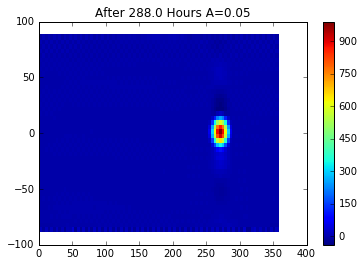

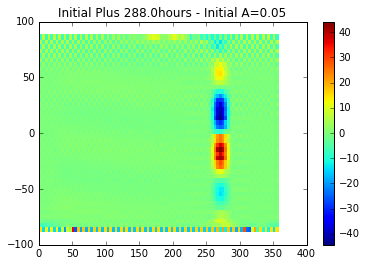

In [8]:
nlat = 45
nlon = 90

lat = linspace(-pi/2,pi/2, nlat + 1)
lat = 0.5*(lat[1:] + lat[:-1])

lon = linspace(0, 2*pi, nlon + 1)
lon = 0.5*(lon[1:] + lon[:-1])

H = empty([len(lat),len(lon)])
u = empty([len(lat),len(lon)])
v = empty([len(lat),len(lon)])

test1 = JLNmodel(lon,lat,H,u,v)
test2 = JLNmodel(lon,lat,H,u,v)
test1.make_cosine_bell_test(alph=1)
test2.make_cosine_bell_test(alph=0)
#test1.plot_current('Initial Cosine Bell')

delta_t = 60
last=60*24*12
for i in arange(0,last):
    test1.RK3(delta_t = delta_t)
    test2.RK3(delta_t = delta_t)
    if i%(60*12) == 0:
        print(i/last)
test1.plot_current('After '+str(delta_t*last/3600)+' Hours A=0.05')

test1.plot_diff('Initial Plus '+str(delta_t*last/3600)+'hours - Initial A=0.05')



#test2 = JLNmodel(lon,lat,H,u,v)
#test2.make_cosine_bell_test(alph=0)
#for i in arange(0,last):
#    test2.RK3(delta_t = delta_t)
#test2.plot_current('After '+str(delta_t*last/3600)+' Hours A=0')
#test2.plot_diff('Initial Plus '+str(delta_t*last/3600)+'hours - Initial A=0')

In [9]:
print(amax(test2.height_current))
print(amax(test1.height_current))

print(amin(test2.height_current))
print(amin(test1.height_current))

999.999961291
990.904935324
-0.000144593562043
-178.145522456


0.0
0.0416666666667
0.0833333333333
0.125
0.166666666667
0.208333333333
0.25
0.291666666667
0.333333333333
0.375
0.416666666667
0.458333333333
0.5
0.541666666667
0.583333333333
0.625
0.666666666667
0.708333333333
0.75
0.791666666667
0.833333333333
0.875
0.916666666667
0.958333333333


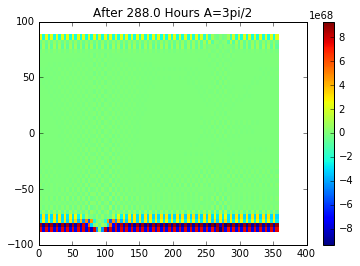

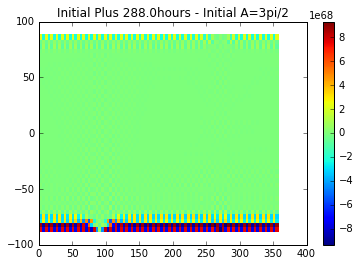

In [10]:
nlat = 45
nlon = 90

lat = linspace(-pi/2,pi/2, nlat + 1)
lat = 0.5*(lat[1:] + lat[:-1])

lon = linspace(0, 2*pi, nlon + 1)
lon = 0.5*(lon[1:] + lon[:-1])

H = empty([len(lat),len(lon)])
u = empty([len(lat),len(lon)])
v = empty([len(lat),len(lon)])

test1 = JLNmodel(lon,lat,H,u,v)
test2 = JLNmodel(lon,lat,H,u,v)
test1.make_cosine_bell_test(alph=3)
test2.make_cosine_bell_test(alph=0)
#test1.plot_current('Initial Cosine Bell')

delta_t = 60
last=60*24*12
for i in arange(0,last):
    test1.RK3(delta_t = delta_t)
    #test2.RK3(delta_t = delta_t)
    if i%(60*12) == 0:
        print(i/last)
test1.plot_current('After '+str(delta_t*last/3600)+' Hours A=3pi/2')

test1.plot_diff('Initial Plus '+str(delta_t*last/3600)+'hours - Initial A=3pi/2')

In [11]:
print(amax(test2.height_current))
print(amax(test1.height_current))

print(amin(test2.height_current))
print(amin(test1.height_current))

1000.0
9.30308243329e+68
0.0
-9.35739344311e+68
